# Machine Learning Lab - Steel Industry
## Part 2: Energy Consumption Prediction

In this part, we will develop machine learning models to predict the energy consumption of a steel industry. This predictive capability is crucial for cost optimization and production planning.

### Objectives:
- Implement different regression models
- Compare their performance
- Interpret the results in an industrial context

### Data structure:

1. **Target variable (to predict):**
   - `Usage_kWh`: Energy consumption in kilowatt-hours

2. **Numerical descriptive variables:**
   - `Lagging_Current_Reactive.Power_kVarh`: Lagging reactive power
   - `Leading_Current_Reactive_Power_kVarh`: Leading reactive power
   - `CO2(tCO2)`: CO2 emissions
   - `Lagging_Current_Power_Factor`: Lagging power factor
   - `Leading_Current_Power_Factor`: Leading power factor
   - `NSM`: Number of Seconds from Midnight (time)

3. **Categorical variables:**
   - `Day_of_week`: Day of the week (Monday to Sunday)
   - `WeekStatus`: Type of day (Weekday/Weekend)

### Applied preprocessing:
1. Standardization of numerical variables (mean=0, std=1)
2. One-hot encoding of categorical variables
3. Train/test split (80%/20%)

### Models covered:
- Linear regression (baseline)
- K-Nearest Neighbors (KNN)
- Decision Trees
- Random Forest
- Neural Networks

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                           explained_variance_score, max_error)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy import stats
import os

# Display configuration
sns.set_theme()  # Use seaborn style directly
plt.rcParams['figure.figsize'] = [10, 6]

--2025-05-28 13:31:47--  https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘steel_industry_data.zip’

steel_industry_data     [ <=>                ] 470.68K  --.-KB/s    in 0.1s    

2025-05-28 13:31:47 (4.76 MB/s) - ‘steel_industry_data.zip’ saved [481973]

Archive:  steel_industry_data.zip
  inflating: Steel_industry_data.csv  
Data downloaded and unzipped.
Data loaded successfully: 35040 observations, 11 variables
Dataset dimensions:
Number of observations: 35,040
Number of variables: 11

Statistical summary of numerical variables:


,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Usage_kWh
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000,27.386892
std,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317,33.444380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000,3.200000
50%,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000,4.570000
75%,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000,51.237500
max,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000,157.180000


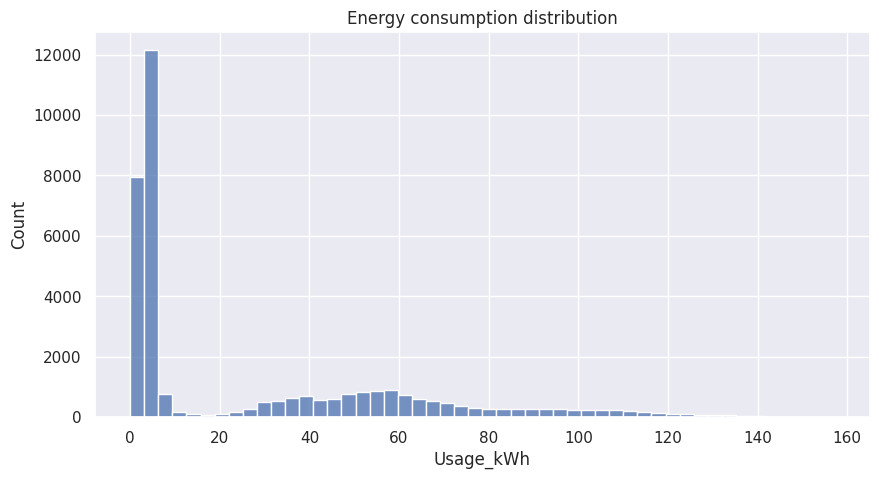

In [2]:
# Download and prepare data
if not os.path.exists('Steel_industry_data.csv'):
    print("Downloading data...")
    # Download the zip file
    !wget -O steel_industry_data.zip https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip
    # Unzip the file
    !unzip -o steel_industry_data.zip
    print("Data downloaded and unzipped.")
else:
    print("Data file already present.")

# Load data
try:
    df = pd.read_csv('Steel_industry_data.csv')
    print(f"Data loaded successfully: {df.shape[0]} observations, {df.shape[1]} variables")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Separate variables
target = 'Usage_kWh'
numeric_features = [
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'CO2(tCO2)',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM'
]
categorical_features = ['Day_of_week', 'WeekStatus', 'period']

# Display dataset dimensions
print("Dataset dimensions:")
print(f"Number of observations: {df.shape[0]:,}")
print(f"Number of variables: {df.shape[1]:,}")

# Statistical summary of numerical variables
print("\nStatistical summary of numerical variables:")
display(df[numeric_features + [target]].describe())

# Target variable distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x=target, bins=50)
# /!\ Complete the '...' to display as the figure title (Matplotlib): Energy consumption distribution /!\
plt.title("Energy consumption distribution")
plt.show()

### 1. Temporal analysis and feature creation

We will structure our temporal data at several levels:
1. Days of the week (Monday to Sunday)
2. Type of day (weekday/weekend)
3. Periods of the day (6 blocks of 4 hours)

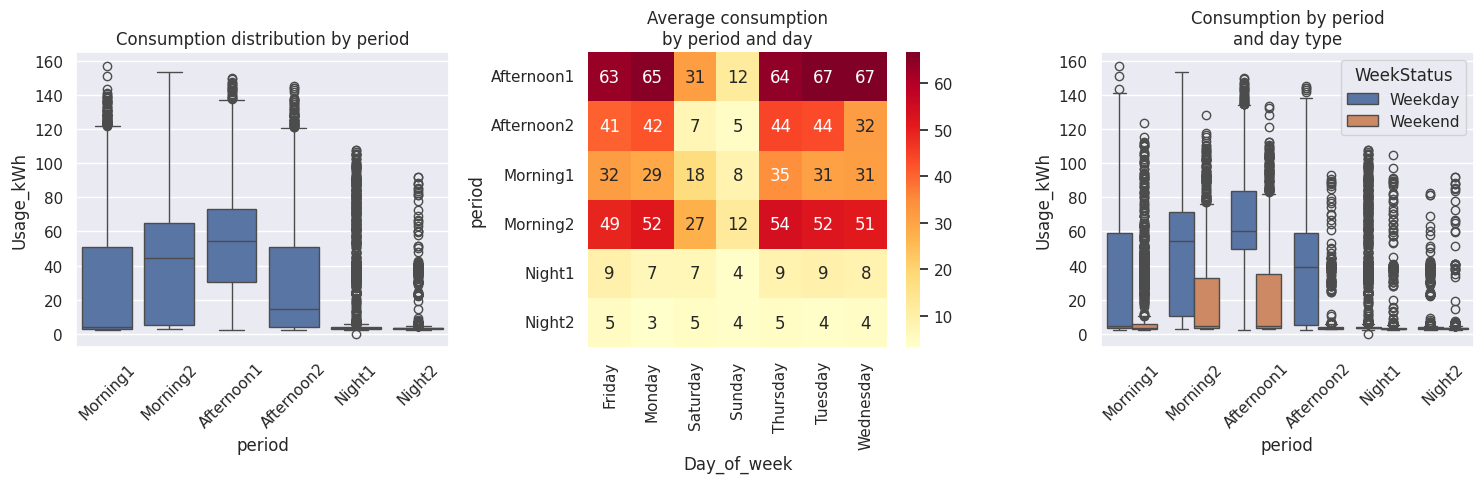


Average consumption (kWh) by period and day type:


mean                                                       std  \
WeekStatus  Weekday                                    Weekend        Weekday   
Day_of_week  Friday Monday Thursday Tuesday Wednesday Saturday Sunday  Friday   
period                                                                          
Afternoon1    63.24  65.48    64.34   66.51     66.71    31.37  12.09   29.33   
Afternoon2    40.65  42.36    44.20   43.58     31.54     7.19   4.61   31.64   
Morning1      31.65  29.23    34.66   30.63     31.39    17.64   8.46   35.80   
Morning2      49.32  51.76    54.18   52.30     50.98    27.28  12.30   33.18   
Night1         9.26   6.83     8.56    9.39      8.44     7.12   3.98   18.16   
Night2         5.06   3.21     4.72    4.16      4.47     4.91   3.84    8.49   

                                                               
WeekStatus                                     Weekend         
Day_of_week Monday Thursday Tuesday Wednesday Saturday Sunday  
period                                                         
Afternoon1   27.59    27.58   28.27     31.70    29.88  18.43  
Afternoon2   32.51    31.41   32.43     31.46    13.25   5.86  
Morning1     34.52    39.79   35.15     35.54    24.14  16.71  
Morning2     35.09    37.06   36.10     35.18    27.15  20.64  
Night1       14.01    16.88   17.48     15.88    14.87   5.37  
Night2        0.53     6.49    4.74      5.32    10.22   4.67

In [5]:
# Creation of industrial day periods
def create_industrial_periods(df):
    # Convert NSM to hours
    df['hour'] = df['NSM'] / 3600

    # Create periods with the day starting at 6am
    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 10),   # Morning1
        (df['hour'] >= 10) & (df['hour'] < 14),  # Morning2
        (df['hour'] >= 14) & (df['hour'] < 18),  # Afternoon1
        (df['hour'] >= 18) & (df['hour'] < 22),  # Afternoon2
        (df['hour'] >= 22) | (df['hour'] < 2),   # Night1
        (df['hour'] >= 2) & (df['hour'] < 6)     # Night2
    ]

    periods = ['Morning1', 'Morning2', 'Afternoon1', 'Afternoon2', 'Night1', 'Night2']
    df['period'] = np.select(conditions, periods, default='Night2')

    return df

# Apply periods
# /!\ Complete the '...' to transform df using the create_industrial_periods() function /!\
df = create_industrial_periods(df)

# Visualization of consumption patterns
plt.figure(figsize=(15, 5))

# 1. Average consumption by period
plt.subplot(1, 3, 1)
period_order = ['Morning1', 'Morning2', 'Afternoon1', 'Afternoon2', 'Night1', 'Night2']
sns.boxplot(data=df, x='period', y='Usage_kWh', order=period_order)
plt.title('Consumption distribution by period')
plt.xticks(rotation=45)

# 2. Heatmap period x day
pivot_period_day = pd.pivot_table(df,
                                values='Usage_kWh',
                                index='period',
                                columns='Day_of_week',
                                aggfunc='mean')
plt.subplot(1, 3, 2)
sns.heatmap(pivot_period_day, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Average consumption\nby period and day')

# 3. Weekday/weekend comparison
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='period', y='Usage_kWh', hue='WeekStatus', order=period_order)
plt.title('Consumption by period\nand day type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Detailed statistics
print("\nAverage consumption (kWh) by period and day type:")
pivot_stats = pd.pivot_table(df,
                           values='Usage_kWh',
                           index='period',
                           columns=['WeekStatus', 'Day_of_week'],
                           aggfunc=['mean', 'std'])
display(pivot_stats.round(2))

❓ **Questions about temporal patterns:**

1. **Production cycles**
   - Which period shows the highest consumption? Why?
   - How does consumption evolve between Morning1 and Morning2?

2. **Day/night variations**
   - What is the difference in consumption between daytime and nighttime periods?
   - Is variability greater during the day or at night?

3. **Weekend impact**
   - How does the consumption pattern change on weekends?
   - Which periods show the greatest weekday/weekend difference?
   - What recommendations for energy optimization?

In [8]:
# Data preparation

# 1. Standardization of numerical variables
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[numeric_features]),
    columns=numeric_features
)

# 2. Encoding of categorical variables
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(df[categorical_features])

# Encoded column names
day_names = [f'Day_{day}' for day in encoder.categories_[0]]
week_status_names = [f'Status_{status}' for status in encoder.categories_[1]]
period_names = [f'Period_{period}' for period in encoder.categories_[2]]
encoded_columns = day_names + week_status_names + period_names

# Check dimensions
print("\nEncoding dimensions:")
print(f"Number of encoded columns: {len(encoded_columns)}")
print(f"Shape of encoded data: {categorical_encoded.shape}")
print("Encoded categories:")
for i, feature in enumerate(categorical_features):
    print(f"{feature}: {list(encoder.categories_[i])}")

# Create DataFrame with encoded variables
df_encoded = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# 3. Combine features
X = pd.concat([df_scaled, df_encoded], axis=1)
# /!\ Complete the '...' to assign the variable y to the target column of the dataframe /!\
y = df[target]

print("Structure of prepared data:")
print(f"Standardized numerical variables: {len(numeric_features)}")
print(f"Encoded categorical variables: {len(encoded_columns)}")
print(f"Final dimensions of X: {X.shape}")

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTrain and test set dimensions:")
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")


Encoding dimensions:
Number of encoded columns: 15
Shape of encoded data: (35040, 15)
Encoded categories:
Day_of_week: ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
WeekStatus: ['Weekday', 'Weekend']
period: ['Afternoon1', 'Afternoon2', 'Morning1', 'Morning2', 'Night1', 'Night2']
Structure of prepared data:
Standardized numerical variables: 6
Encoded categorical variables: 15
Final dimensions of X: (35040, 21)

Train and test set dimensions:
X_train : (28032, 21)
X_test : (7008, 21)
y_train : (28032,)
y_test : (7008,)


### 2. Linear regression

To understand how linear regression finds its coefficients, let's implement our own version:

y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ

The loss (mean squared error) is:
L = (1/n) Σ(y_pred - y_true)²

The coefficients are updated as:
β_new = β_old - α * ∂L/∂β
where α is the learning rate

Iteration 1000/15000, Loss: 27.4440
Iteration 2000/15000, Loss: 24.2076
Iteration 3000/15000, Loss: 23.3008
Iteration 4000/15000, Loss: 23.0235
Iteration 5000/15000, Loss: 22.9324
Iteration 6000/15000, Loss: 22.9003
Iteration 7000/15000, Loss: 22.8884
Iteration 8000/15000, Loss: 22.8838
Iteration 9000/15000, Loss: 22.8819
Iteration 10000/15000, Loss: 22.8811
Iteration 11000/15000, Loss: 22.8808
Iteration 12000/15000, Loss: 22.8807
Iteration 13000/15000, Loss: 22.8806
Iteration 14000/15000, Loss: 22.8806
Iteration 15000/15000, Loss: 22.8806

Comparison of the two implementations:

Performance metrics:


,GD,Sklearn
R² score,0.9843,0.9843
MSE,17.8908,17.8882
RMSE,4.2298,4.2294



Coefficient comparison:


,Feature,GD,Sklearn,Difference
0,Lagging_Current_Reactive.Power_kVarh,5.4098,5.4052,0.0045
1,Leading_Current_Reactive_Power_kVarh,0.9523,0.9484,0.0039
2,CO2(tCO2),26.4665,26.4731,0.0065
3,Lagging_Current_Power_Factor,2.2914,2.2904,0.0011
4,Leading_Current_Power_Factor,2.4144,2.4083,0.0060
5,NSM,0.0710,0.0721,0.0010
6,Day_Friday,1.5277,-0.1311,1.6588
7,Day_Monday,1.5366,-0.1224,1.6589
8,Day_Saturday,3.2727,-0.0450,3.3177
9,Day_Sunday,3.2847,-0.0337,3.3184



Regression equation:
Usage_kWh = 14.93 + (26.47 × CO2(tCO2)) + (8.37 × Status_Weekday) + (6.56 × Status_Weekend) + (5.41 × Lagging_Current_Reactive.Power_kVarh) + (3.75 × Period_Afternoon1) + (3.28 × Day_Sunday) + (3.27 × Day_Saturday) + (3.06 × Period_Afternoon2) + (2.75 × Period_Morning2) + (2.41 × Leading_Current_Power_Factor) + (2.29 × Lagging_Current_Power_Factor) + (2.24 × Day_Tuesday) + (1.96 × Period_Night2) + (1.83 × Period_Night1) + (1.61 × Day_Wednesday) + (1.58 × Period_Morning1) + (1.54 × Day_Monday) + (1.53 × Day_Friday) + (1.46 × Day_Thursday) + (0.95 × Leading_Current_Reactive_Power_kVarh) + (0.07 × NSM) 



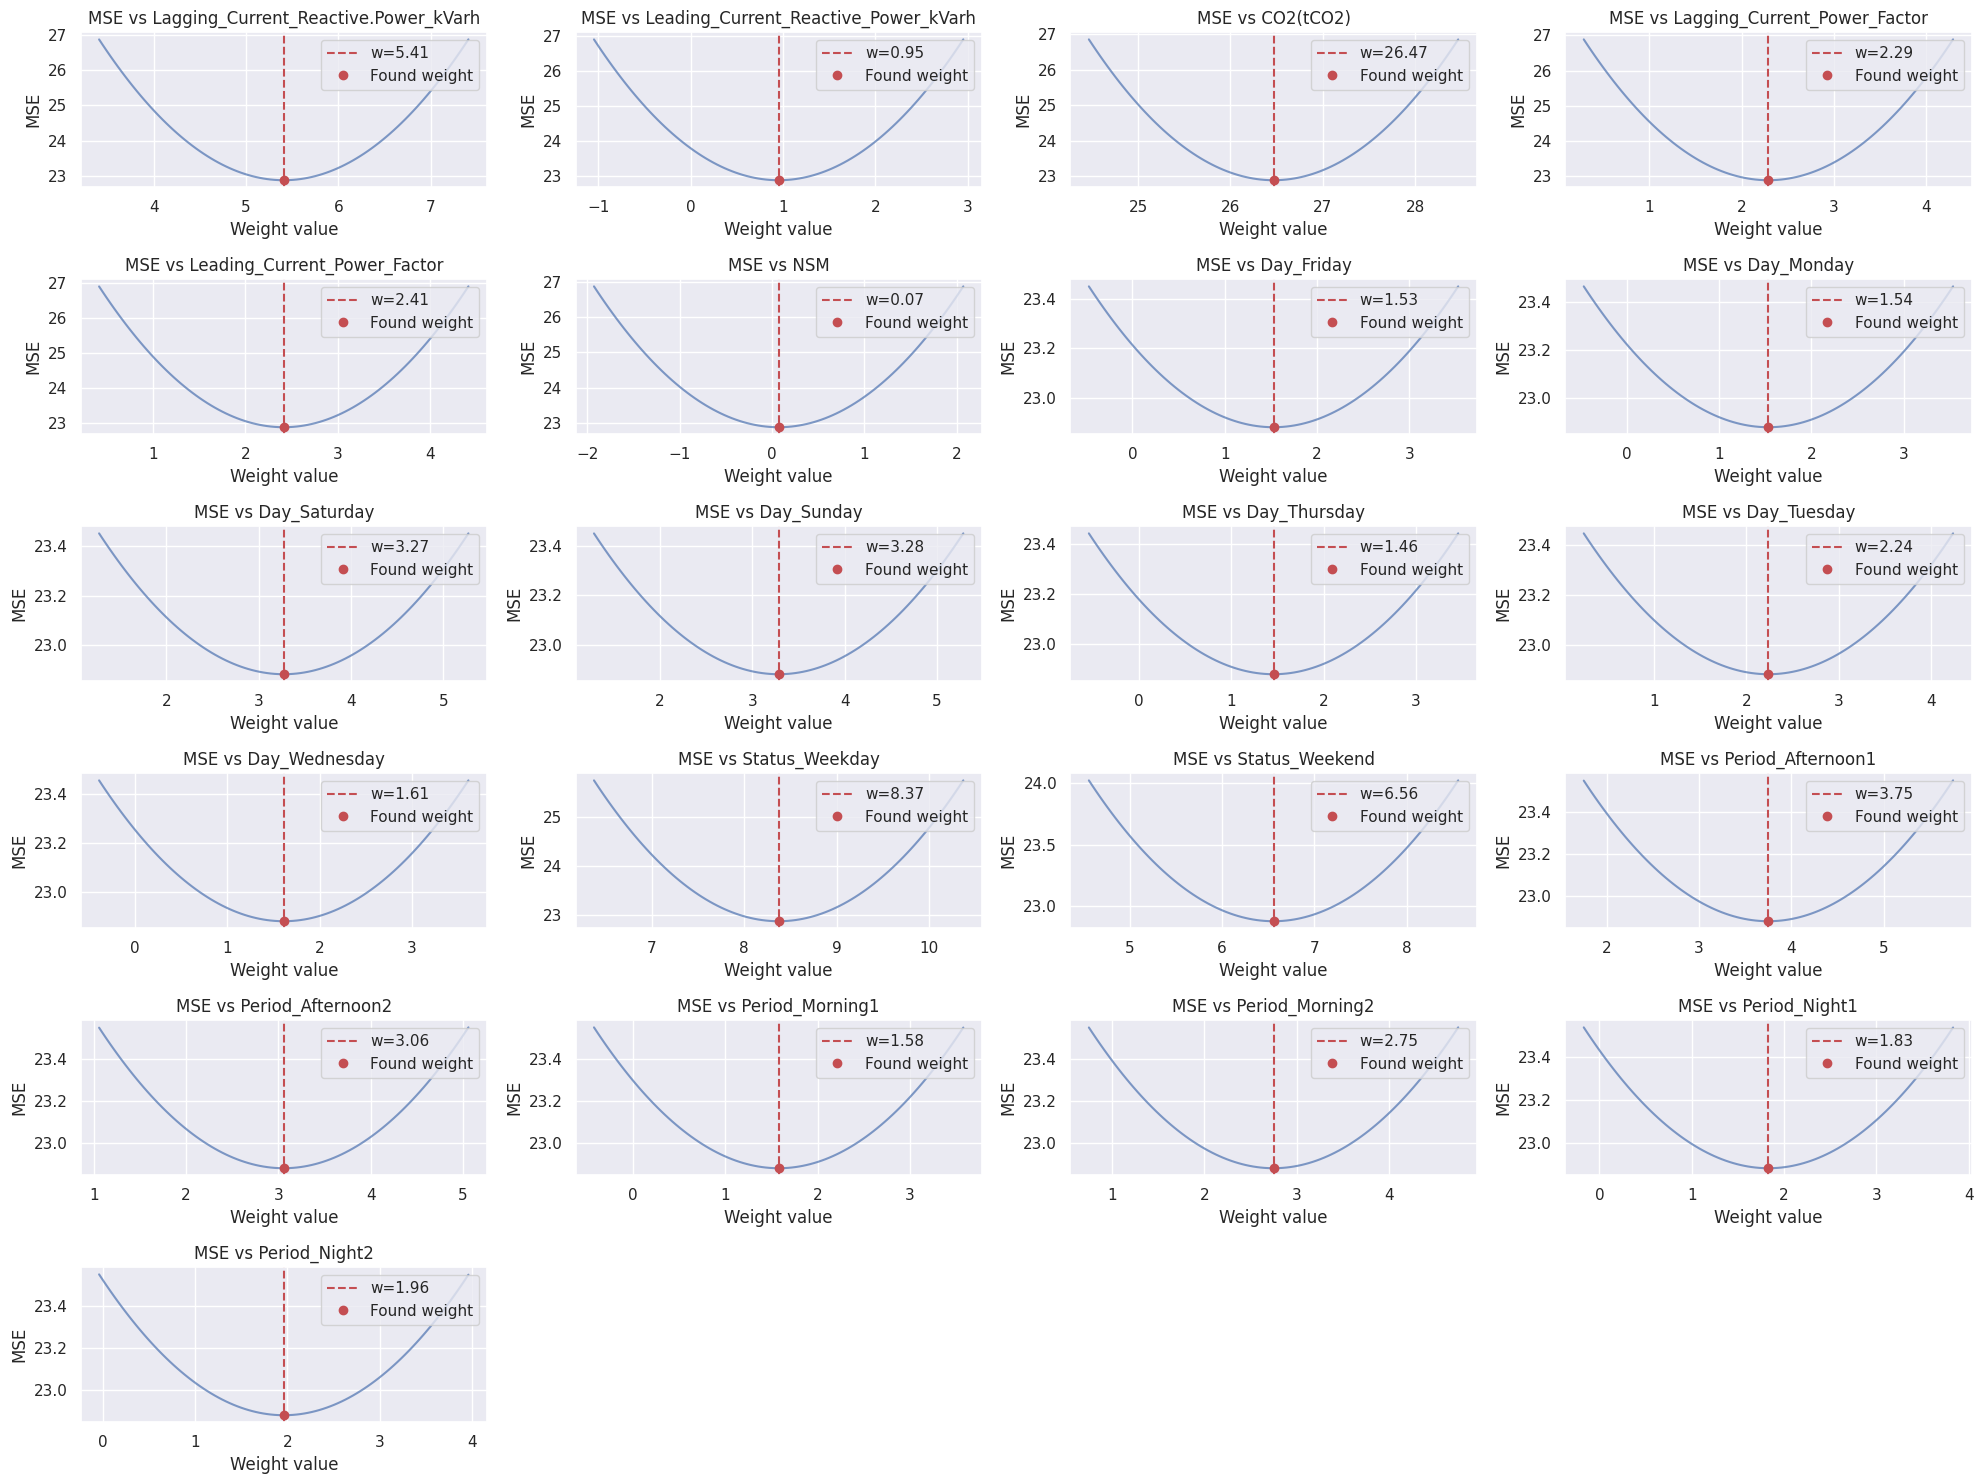

In [9]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.weights_history = []
        self.bias_history = []

    def fit(self, X, y):
        # Parameter initialization
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # History for visualization
        self.loss_history = []
        self.weights_history = []
        self.bias_history = []

        # Gradient descent
        for i in range(self.n_iterations):
            # Current prediction
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # Compute and save loss and parameters
            loss = np.mean((y_pred - y) ** 2)
            self.loss_history.append(loss)
            self.weights_history.append(self.weights.copy())
            self.bias_history.append(self.bias)

            # Display progress
            if (i+1) % 1000 == 0:
                print(f'Iteration {i+1}/{self.n_iterations}, Loss: {loss:.4f}')

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Visualization of error as a function of each weight
def plot_error_vs_weights(X, y, weights, bias, feature_names, n_points=100):
    plt.figure(figsize=(20, 15))
    n_features = len(weights)
    n_rows = (n_features + 3) // 4  # Ceiling division for number of rows

    for i, (feature_name, weight) in enumerate(zip(feature_names, weights)):
        # Create a range of values around the optimal weight
        weight_range = np.linspace(weight - 2, weight + 2, n_points)
        errors = []

        # Compute error for each weight value
        for w in weight_range:
            weights_temp = weights.copy()
            weights_temp[i] = w
            y_pred = np.dot(X, weights_temp) + bias
            mse = np.mean((y - y_pred) ** 2)
            errors.append(mse)

        # Plot error curve
        plt.subplot(n_rows, 4, i+1)
        plt.plot(weight_range, errors, 'b-', alpha=0.7)
        plt.axvline(x=weight, color='r', linestyle='--', label=f'w={weight:.2f}')
        plt.title(f'MSE vs {feature_name}')
        plt.xlabel('Weight value')
        plt.ylabel('MSE')
        plt.grid(True)

        # Mark the found weight
        plt.plot(weight, np.min(errors), 'ro', label='Found weight')
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Train both models
lr_gd = LinearRegressionGD(learning_rate=0.01, n_iterations=15000)
# /!\ Complete the '...' to apply linear regression lr_gd to the data /!\
lr_gd.fit(X_train.values, y_train.values)

lr_sk = LinearRegression()
# /!\ Complete the '...' to apply linear regression lr_sk to the data /!\
lr_sk.fit(X_train, y_train)

# Performance comparison
print("\nComparison of the two implementations:")
comparison = pd.DataFrame(columns=['GD', 'Sklearn'])

# Predictions
y_pred_gd = lr_gd.predict(X_test.values)
y_pred_sk = lr_sk.predict(X_test)

# Metrics
comparison.loc['R² score'] = [
    r2_score(y_test, y_pred_gd),
    r2_score(y_test, y_pred_sk)
]
comparison.loc['MSE'] = [
    mean_squared_error(y_test, y_pred_gd),
    mean_squared_error(y_test, y_pred_sk)
]
comparison.loc['RMSE'] = [
    np.sqrt(mean_squared_error(y_test, y_pred_gd)),
    np.sqrt(mean_squared_error(y_test, y_pred_sk))
]

print("\nPerformance metrics:")
display(comparison.round(4))

# Coefficient comparison
coef_comparison = pd.DataFrame({
    'Feature': X_train.columns,
    'GD': lr_gd.weights,
    'Sklearn': lr_sk.coef_,
    'Difference': np.abs(lr_gd.weights - lr_sk.coef_)
})

print("\nCoefficient comparison:")
display(coef_comparison.round(4))

# Display the full equation (with the 5 most important coefficients)
print("\nRegression equation:")
print(f"Usage_kWh = {lr_gd.bias:.2f}", end=" ")
top_coefs = coef_comparison.assign(abs_coef=lambda x: np.abs(x['GD'])).nlargest(21, 'abs_coef')
for _, row in top_coefs.iterrows():
    print(f"+ ({row['GD']:.2f} × {row['Feature']})", end=" ")
print("\n")

# Visualization of error curves
plot_error_vs_weights(X_train.values, y_train.values,
                     lr_gd.weights, lr_gd.bias,
                     feature_names=X_train.columns)

### Interpretation of metrics:

1. **R² (Coefficient of determination)**
   - Ranges between 0 and 1 (or negative if the model is very poor)
   - The closer to 1, the better the model
   - Represents the proportion of variance explained by the model
   - An R² of 0.8 means the model explains 80% of the data variability

2. **MSE (Mean Squared Error)**
   - Mean of squared errors
   - Heavily penalizes large errors
   - Hard to interpret because the unit is squared

3. **RMSE (Root Mean Squared Error)**
   - Square root of the MSE
   - Same unit as the target variable (kWh)
   - Easier to interpret: average error in kWh
   - Example: RMSE = 10 means an average error of ±10 kWh

❓ **In-depth questions about linear regression:**

1. **Convergence**
   - How does the loss evolve over iterations?
   - Why is the decrease fast at first and then slower?
   - How do you know if the global minimum is reached?

2. **Comparison with sklearn**
   - Are the coefficients similar?
   - Why are there differences?

3. **Mathematical understanding**
   - Why use MSE (Mean Squared Error) as the loss function?

4. **Coefficient analysis**
   - Why does CO2(tCO2) have the largest coefficient (26.47)?
   - Do negative coefficients mean a negative influence?

5. **Error curves**
   - Why do the curves have a parabolic shape?
   - What does the width of the parabola mean for each feature?
   - Why do some features have a greater impact?

### 3. K-Nearest Neighbors (KNN)
The K-Nearest Neighbors algorithm is a non-parametric method that predicts consumption based on the k most similar observations.

Memorizing 28032 training observations

Test with k=1:

Prediction details:
Observation to predict: [-0.59643827 -0.52138505 -0.71355023 -0.36827002  0.51326762  1.67801526
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.        ]

Nearest neighbors found:
Neighbor 1:
- Distance: 0.04
- Value: 3.71

Final prediction: 3.71

Global metrics:
R² score: 0.992
MSE: 9.137
RMSE: 3.023
Memorizing 28032 training observations

Test with k=2:

Prediction details:
Observation to predict: [-0.59643827 -0.52138505 -0.71355023 -0.36827002  0.51326762  1.67801526
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.        ]

Nearest neighbors found:
Neighbor 1:
- Distance: 0.04
- Value: 3.71
Neighbor 2:
- Distance: 0.04
- Value: 3.85

Final prediction: 3.78

Global metrics:
R² score: 0.993


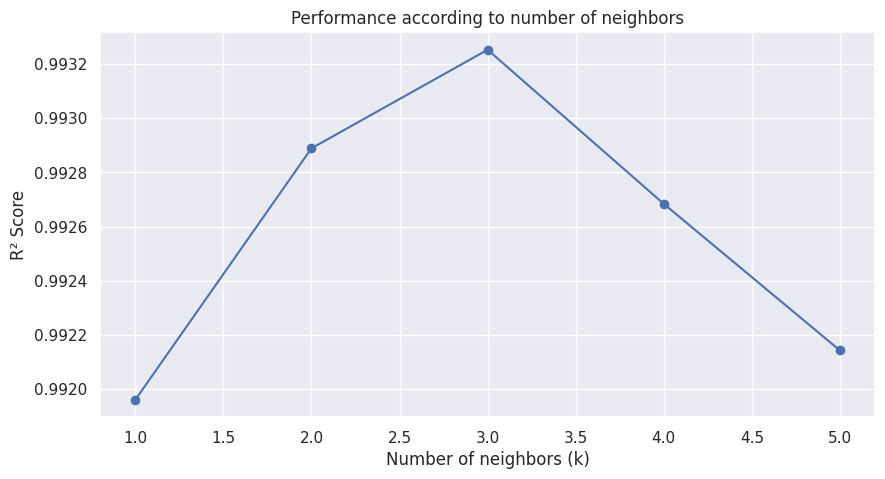

In [10]:
class SimpleKNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """Simply memorizes the training data"""
        self.X_train = X
        self.y_train = y
        print(f"Memorizing {len(X)} training observations")

    def predict_single(self, x, verbose=False):
        """Predicts for a single observation with option to display details"""
        # Compute distances to all training points
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))

        # Find the k nearest neighbors
        nearest_indices = np.argsort(distances)[:self.k]
        nearest_distances = distances[nearest_indices]

        if verbose:
            print("\nPrediction details:")
            print(f"Observation to predict: {x}")
            print("\nNearest neighbors found:")
            for i, (idx, dist) in enumerate(zip(nearest_indices, nearest_distances)):
                print(f"Neighbor {i+1}:")
                print(f"- Distance: {dist:.2f}")
                print(f"- Value: {self.y_train[idx]:.2f}")

        # Compute prediction (simple mean)
        prediction = np.mean(self.y_train[nearest_indices])

        if verbose:
            print(f"\nFinal prediction: {prediction:.2f}")

        return prediction

    def predict(self, X):
        """Predicts for multiple observations"""
        return np.array([self.predict_single(x) for x in X])

# Test with different values of k
k_values = [1, 2, 3, 4, 5]
knn_scores = []

# Create a simple example for visualization
example_idx = 42  # An arbitrary index for the example

for k in k_values:
    knn = SimpleKNN(k=k)
    knn.fit(X_train.values, y_train.values)

    # Detailed prediction for the example
    print(f"\nTest with k={k}:")
    example_pred = knn.predict_single(X_test.values[example_idx], verbose=True)

    # Compute metrics
    y_pred = knn.predict(X_test.values)
    # /!\ Complete the '...' to compute the R² between the true target value and the prediction /!\
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    knn_scores.append(r2)

    print(f"\nGlobal metrics:")
    print(f"R² score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")

# Visualization of the impact of k
plt.figure(figsize=(10, 5))
plt.plot(k_values, knn_scores, 'bo-')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('R² Score')
plt.title('Performance according to number of neighbors')
plt.grid(True)
plt.show()

❓ **Questions about the KNN algorithm:**

1. **Algorithm understanding**
   - How does KNN make predictions for a new observation?
   - Why is it important for variables to be standardized?

2. **Choice of k**
   - What happens if k is too small (k=1)?
   - What happens if k is too large (k close to n)?
   - Why do we observe an optimal k in the performance curve?

3. **Interpretability**
   - How to explain a KNN prediction to a user?
   - Can we identify the most important variables?

### 4. Decision Trees
Decision trees allow the creation of easily interpretable prediction rules.
They can capture non-linear relationships and are particularly useful in an industrial context.

Key points:
- Transparent and interpretable model
- Able to capture non-linear relationships
- Risk of overfitting to be controlled

The decision tree recursively splits the data into homogeneous subgroups by choosing the best variables and split thresholds.

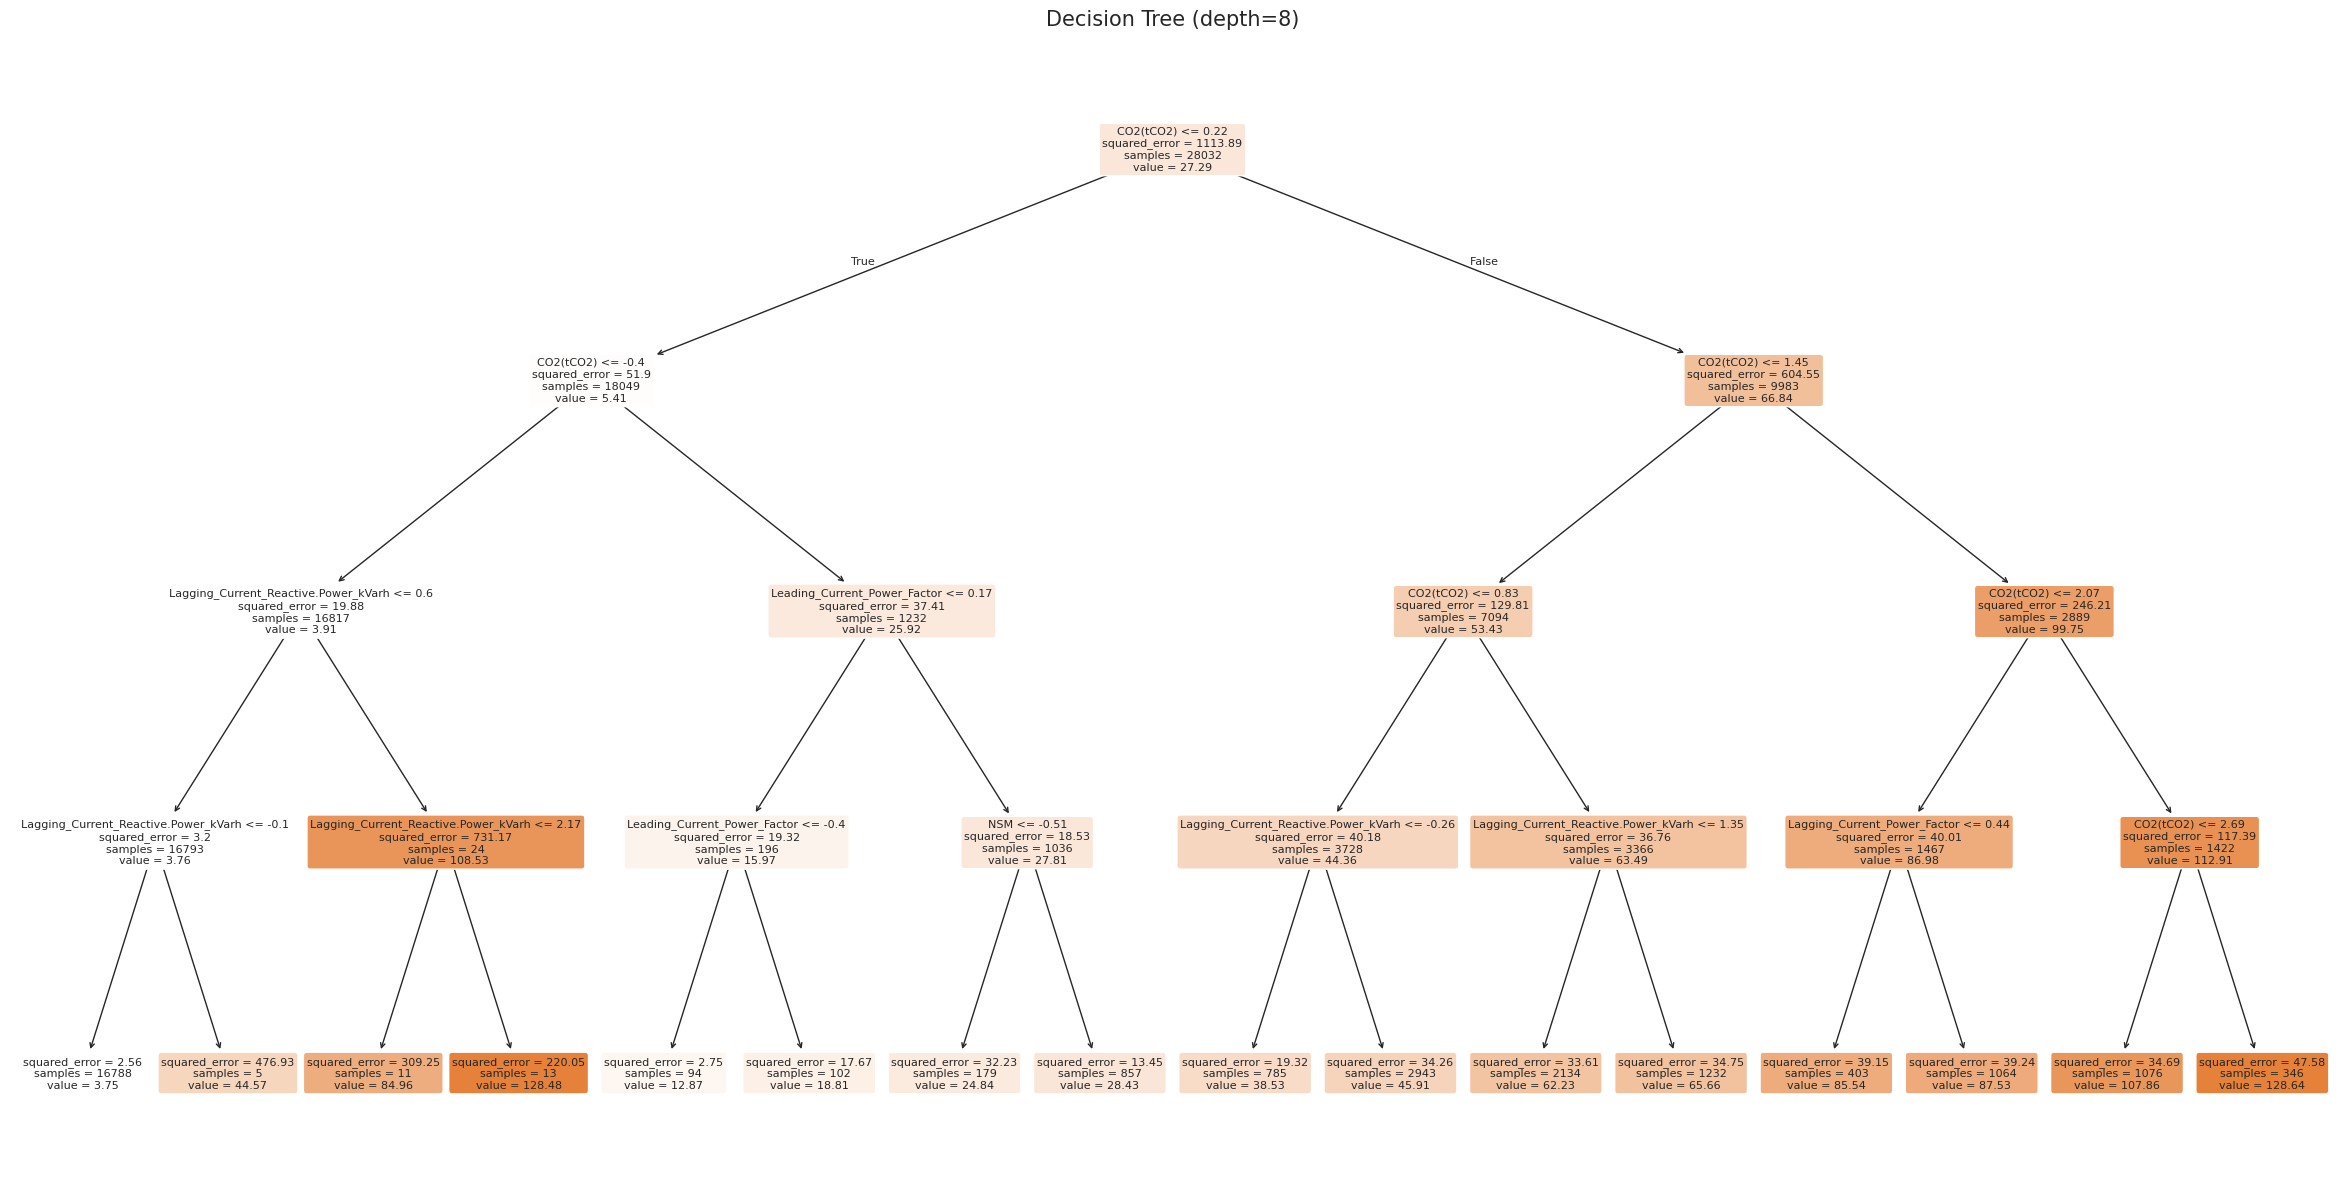


Details of the instance to predict:

Actual consumption value: 3.60 kWh
Predicted value: 3.75 kWh

Non-zero features of the instance:
Lagging_Current_Reactive.Power_kVarh: -0.60
Leading_Current_Reactive_Power_kVarh: -0.52
CO2(tCO2): -0.71
Lagging_Current_Power_Factor: -0.37
Leading_Current_Power_Factor: 0.51
NSM: 1.68
Day_Tuesday: 1.00
Status_Weekday: 1.00
Period_Night1: 1.00

Detailed decision path:

Level 1:
   Test: CO2(tCO2) ≤ 0.22
   Measured value: -0.71
   Number of observations: 28032
   Group mean: 27.29 kWh
   → Left branch (condition true)

Level 2:
   Test: CO2(tCO2) ≤ -0.40
   Measured value: -0.71
   Number of observations: 18049
   Group mean: 5.41 kWh
   → Left branch (condition true)

Level 3:
   Test: Lagging_Current_Reactive.Power_kVarh ≤ 0.60
   Measured value: -0.60
   Number of observations: 16817
   Group mean: 3.91 kWh
   → Left branch (condition true)

Level 4:
   Test: Lagging_Current_Reactive.Power_kVarh ≤ -0.1
   Measured value: -0.60
   Number of observati

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


DecisionTreeRegressor(max_depth=10)

In [11]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Create and train the tree with depth 4
dt = DecisionTreeRegressor(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

# Visualization of the tree with better readability
plt.figure(figsize=(30, 15))  # Large size for readability
plot_tree(dt,
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=8,  # Font size
          precision=2)  # Number of decimals for values
plt.title('Decision Tree (depth=8)', fontsize=15)
plt.show()

# Example of detailed prediction
example_idx = 42
example = X_test.iloc[example_idx]
real_value = y_test.iloc[example_idx]
prediction = dt.predict([example])[0]

print("\nDetails of the instance to predict:")
print(f"\nActual consumption value: {real_value:.2f} kWh")
print(f"Predicted value: {prediction:.2f} kWh")

print("\nNon-zero features of the instance:")
for feature, value in example.items():
    if abs(value) > 0.01:  # Only display non-zero values
        print(f"{feature}: {value:.2f}")

print("\nDetailed decision path:")

print("\nLevel 1:")
print("   Test: CO2(tCO2) ≤ 0.22")
print("   Measured value: -0.71")
print("   Number of observations: 28032")
print("   Group mean: 27.29 kWh")
print("   → Left branch (condition true)")

print("\nLevel 2:")
print("   Test: CO2(tCO2) ≤ -0.40")
print("   Measured value: -0.71")
print("   Number of observations: 18049")
print("   Group mean: 5.41 kWh")
print("   → Left branch (condition true)")

print("\nLevel 3:")
print("   Test: Lagging_Current_Reactive.Power_kVarh ≤ 0.60")
print("   Measured value: -0.60")
print("   Number of observations: 16817")
print("   Group mean: 3.91 kWh")
print("   → Left branch (condition true)")

print("\nLevel 4:")
print("   Test: Lagging_Current_Reactive.Power_kVarh ≤ -0.1")
print("   Measured value: -0.60")
print("   Number of observations: 16793")
print("   Group mean: 3.76 kWh")
print("   → Left branch (condition true)")

print("\n→ Final leaf:")
print("   - Number of observations: 16788")
print("   - Predicted value: 3.75 kWh")

# Performance metrics
y_pred = dt.predict(X_test)
print("\nPerformance metrics:")
print(f"R² score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.1f}")

# Create and train the tree with depth 10
# /!\ Complete the '...' to train a decision tree with depth 10 /!\
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

#

❓ **Questions:**
1. What are the most important variables according to the decision tree?

2. How does tree depth influence performance?

3. [OPTIONAL] **Tree structure**
   - Why is CO2(tCO2) often chosen as the first split?
   - How does the number of observations decrease at each level?
   - What is the meaning of the average values in the nodes?

4. [OPTIONAL] **Prediction process**
   - How does the tree arrive at its final prediction?
   - Why are predictions more accurate with greater depth?

### 5. Random Forest
Random Forest is an ensemble of decision trees that improves generalization and prediction stability compared to a single tree.

Key points:
- Better generalization than a single tree
- Robust estimation of variable importance
- Reduced overfitting

In [12]:
# Create a simple Random Forest with 500 trees for visualization
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Example of detailed prediction
example_idx = 42
example = X_test.iloc[example_idx]
real_value = y_test.iloc[example_idx]

print("\nDetails of the instance to predict:")
print(f"Actual consumption value: {real_value:.2f} kWh")

print("\nImportant features of the instance:")
for feature, value in example.items():
    if abs(value) > 0.01:  # Only display non-zero values
        print(f"{feature}: {value:.2f}")

# Prediction of each tree
print("\nPredictions of individual trees:")
predictions = []
for i, tree in enumerate(rf.estimators_):
    pred = tree.predict([example])[0]
    predictions.append(pred)
    # print(f"\nTree {i+1}:")
    # print(f"Prediction: {pred:.2f} kWh")

    # Display the decision path for this tree
    path = tree.decision_path([example])
    feature_path = []
    for node_id in path.indices:
        if node_id == tree.tree_.children_left[path.indices[0]]:  # If it's a leaf
            continue
        feature = X_train.columns[tree.tree_.feature[node_id]]
        threshold = tree.tree_.threshold[node_id]
        value = example[feature]
        direction = "left" if value <= threshold else "right"
        feature_path.append(f"   {feature} ≤ {threshold:.2f} ? {value:.2f} → {direction}")

    # print("Decision path:")
    # for step in feature_path:
    #     print(step)

# Final prediction (mean of the trees)
# /!\ Complete the '...' to get the mean of the predictions (Numpy) /!\
final_prediction = np.mean(predictions)
print(f"\nFinale predicction (mean of the trees): {final_prediction:.2f} kWh")

# Performance Metrics
y_pred = rf.predict(X_test)
print("\nPerformance Metrics:")
print(f"R² score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.1f}")

# Variables importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 5 most important variables:")
print(importance.head().to_string())


Details of the instance to predict:
Actual consumption value: 3.60 kWh

Important features of the instance:
Lagging_Current_Reactive.Power_kVarh: -0.60
Leading_Current_Reactive_Power_kVarh: -0.52
CO2(tCO2): -0.71
Lagging_Current_Power_Factor: -0.37
Leading_Current_Power_Factor: 0.51
NSM: 1.68
Day_Tuesday: 1.00
Status_Weekday: 1.00
Period_Night1: 1.00

Predictions of individual trees:

Finale predicction (mean of the trees): 3.73 kWh

Performance Metrics:
R² score: 0.997
RMSE: 1.9

Top 5 most important variables:
                                Feature  Importance
2                             CO2(tCO2)    0.978560
0  Lagging_Current_Reactive.Power_kVarh    0.014591
3          Lagging_Current_Power_Factor    0.004208
4          Leading_Current_Power_Factor    0.001201
5                                   NSM    0.000852


❓ **Questions:**
1. Why does Random Forest perform better than a single tree?

2. [OPTIONAL] Compare variable importance between Random Forest and a single tree.
   Which estimation seems more reliable to you? Why?

3. [OPTIONAL] **Voting mechanism**
   - Why take the average of the predictions from the trees?

4. **Advantages over a single tree**
   - How does Random Forest avoid overfitting?
   - Why are predictions more stable?

### 6. Neural Networks (MLP)
The Multi-Layer Perceptron is a neural network capable of capturing complex relationships between variables. It is particularly effective for non-linear problems.

Key points:
- High learning capacity
- Able to capture complex relationships
- Requires fine-tuning of hyperparameters

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Details of the instance to predict:
Actual consumption value: 3.60 kWh
Predicted value: 3.77 kWh

Important features of the instance:
Lagging_Current_Reactive.Power_kVarh: -0.60
Leading_Current_Reactive_Power_kVarh: -0.52
CO2(tCO2): -0.71
Lagging_Current_Power_Factor: -0.37
Leading_Current_Power_Factor: 0.51
NSM: 1.68
Day_Tuesday: 1.00
Status_Weekday: 1.00
Period_Night1: 1.00

Architecture comparison:


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (12,):
- Number of neurons per layer: Input(21) → 12 → Output(1)
- Total number of parameters: 3,540
- Prediction for the example: 3.60 kWh
- Global R² score: 0.998


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (25,):
- Number of neurons per layer: Input(21) → 25 → Output(1)
- Total number of parameters: 14,200
- Prediction for the example: 3.62 kWh
- Global R² score: 0.999


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (12, 6):
- Number of neurons per layer: Input(21) → 12 → 6 → Output(1)
- Total number of parameters: 19,158
- Prediction for the example: 3.77 kWh
- Global R² score: 0.998


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (25, 12):
- Number of neurons per layer: Input(21) → 25 → 12 → Output(1)
- Total number of parameters: 162,462
- Prediction for the example: 3.34 kWh
- Global R² score: 0.999


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (25, 12, 6):
- Number of neurons per layer: Input(21) → 25 → 12 → 6 → Output(1)
- Total number of parameters: 180,960
- Prediction for the example: 3.94 kWh
- Global R² score: 0.999


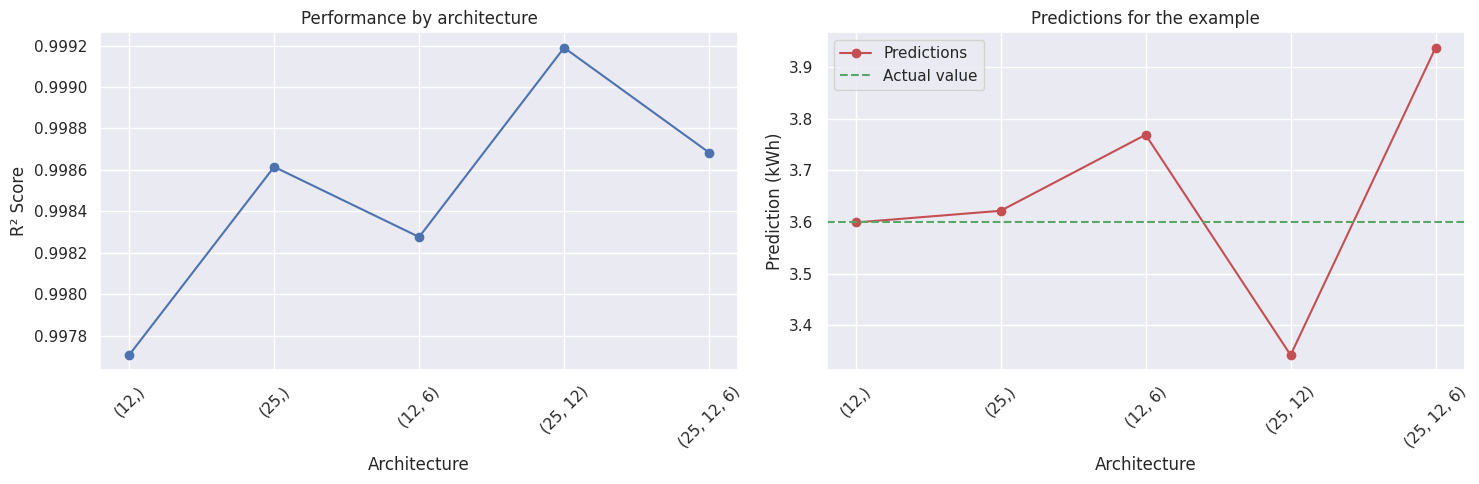

In [13]:
# Create a simple MLP for visualization
mlp = MLPRegressor(hidden_layer_sizes=(12, 6),
                  max_iter=250,
                  activation='relu',
                  solver='adam',
                  random_state=42)
# /!\ Complete the '...' so that the neural network learns to predict y_train from X_train /!\
mlp.fit(X_train, y_train)

# Example of detailed prediction
example_idx = 42
example = X_test.iloc[example_idx]
real_value = y_test.iloc[example_idx]
prediction = mlp.predict([example])[0]

print("\nDetails of the instance to predict:")
print(f"Actual consumption value: {real_value:.2f} kWh")
print(f"Predicted value: {prediction:.2f} kWh")

print("\nImportant features of the instance:")
for feature, value in example.items():
    if abs(value) > 0.01:  # Only display non-zero values
        print(f"{feature}: {value:.2f}")

# Test different architectures
architectures = [(12,), (25,), (12, 6), (25, 12), (25, 12, 6)]
mlp_scores = []
mlp_predictions = []

print("\nArchitecture comparison:")
for arch in architectures:
    # Create and train the model
    mlp = MLPRegressor(hidden_layer_sizes=arch,
                      max_iter=250,
                      random_state=42)
    mlp.fit(X_train, y_train)

    # Compute the number of parameters
    n_params = sum(layer.size * next_layer.size + next_layer.size
                  for layer, next_layer in zip([np.array([X_train.shape[1]])] + mlp.coefs_[:-1],
                                             mlp.coefs_))

    # Prediction for the example
    pred = mlp.predict([example])[0]
    mlp_predictions.append(pred)

    # Global score
    score = r2_score(y_test, mlp.predict(X_test))
    mlp_scores.append(score)

    print(f"\nArchitecture {arch}:")
    print(f"- Number of neurons per layer: Input({X_train.shape[1]}) → {' → '.join(str(x) for x in arch)} → Output(1)")
    print(f"- Total number of parameters: {n_params:,}")
    print(f"- Prediction for the example: {pred:.2f} kWh")
    print(f"- Global R² score: {score:.3f}")

# Visualization of results
plt.figure(figsize=(15, 5))

# R² scores
plt.subplot(1, 2, 1)
plt.plot(range(len(architectures)), mlp_scores, 'bo-')
plt.xticks(range(len(architectures)), [str(arch) for arch in architectures], rotation=45)
plt.xlabel('Architecture')
plt.ylabel('R² Score')
plt.title('Performance by architecture')
plt.grid(True)

# Predictions for the example
plt.subplot(1, 2, 2)
plt.plot(range(len(architectures)), mlp_predictions, 'ro-', label='Predictions')
plt.axhline(y=real_value, color='g', linestyle='--', label='Actual value')
plt.xticks(range(len(architectures)), [str(arch) for arch in architectures], rotation=45)
plt.xlabel('Architecture')
plt.ylabel('Prediction (kWh)')
plt.title('Predictions for the example')
plt.legend()

plt.tight_layout()
plt.show()

❓ **Questions about the MLP:**

1. **Network architecture**
   - Why use multiple hidden layers?
   - How to choose the number of neurons per layer?

2. **Architecture comparison**
   - Which architecture gives the best results? Why?
   - [OPTIONAL] Is there a trade-off between complexity and performance?

### 7. Final model comparison

Let's now compare all the models to choose the most suitable for our problem.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warni


Predictions for the example (actual consumption: 3.60 kWh):
Linear regression: 5.28 kWh
KNN: 4.04 kWh
Decision tree: 3.75 kWh
Random Forest: 3.73 kWh
MLP: 3.34 kWh

Global metrics:
               Model     R²     MSE   RMSE
0  Linear regression  0.984  17.888  4.229
1                KNN  0.993   7.670  2.769
2      Decision tree  0.995   5.399  2.324
3      Random Forest  0.997   3.638  1.907
4                MLP  0.999   0.921  0.960


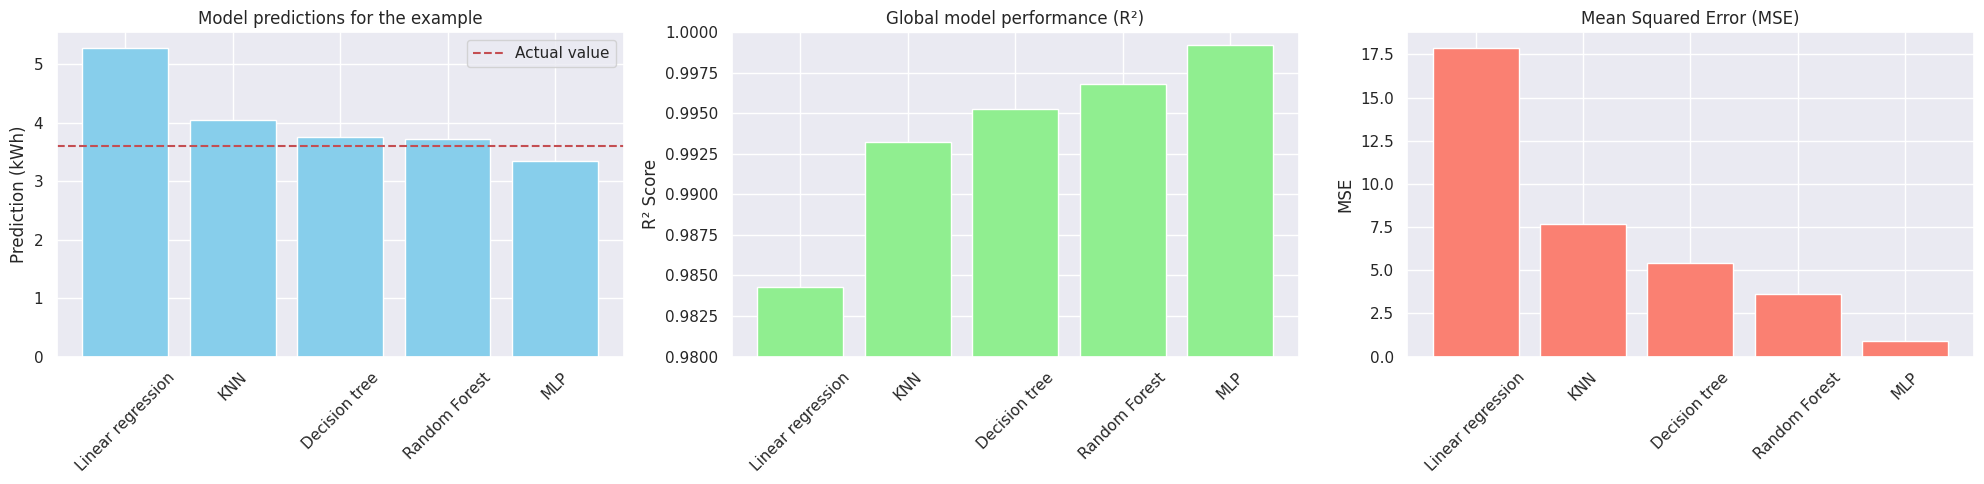

In [15]:
# Create and train the best models
# 1. Linear regression (already created)
lr_sk = LinearRegression()
lr_sk.fit(X_train, y_train)

# 2. KNN (with the best k found)
knn_best = KNeighborsRegressor(n_neighbors=3)  # k=3 gave the best results
knn_best.fit(X_train, y_train)

# 3. Decision tree (already created)
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)

# 4. Random Forest (already created)
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# 5. MLP (already created)
mlp = MLPRegressor(hidden_layer_sizes=(25, 12), max_iter=250, random_state=42)
mlp.fit(X_train, y_train)

example_idx = 42
example = X_test.iloc[example_idx]
real_value = y_test.iloc[example_idx]

# Model dictionary
models = {
    'Linear regression': lr_sk,
    'KNN': knn_best,
    'Decision tree': dt,
    'Random Forest': rf,
    'MLP': mlp
}

# Detailed comparison
print("\nPredictions for the example (actual consumption: {:.2f} kWh):".format(real_value))
predictions = {}
for name, model in models.items():
    pred = model.predict([example])[0]
    predictions[name] = pred
    print(f"{name}: {pred:.2f} kWh")

# Compute global metrics
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# /!\ Complete the '...' to assign to results_df a dataframe containing the results /!\
results_df = pd.DataFrame(results)
print("\nGlobal metrics:")
print(results_df.round(3))

# Visualization of comparisons
plt.figure(figsize=(20, 5))

# 1. Predictions on the example
plt.subplot(1, 3, 1)
plt.bar(predictions.keys(), predictions.values(), color='skyblue')
plt.axhline(y=real_value, color='r', linestyle='--', label='Actual value')
plt.xticks(rotation=45)
plt.ylabel('Prediction (kWh)')
plt.title('Model predictions for the example')
plt.legend()

# 2. R² scores
plt.subplot(1, 3, 2)
plt.bar(results_df['Model'], results_df['R²'], color='lightgreen')
plt.xticks(rotation=45)
plt.ylabel('R² Score')
plt.title('Global model performance (R²)')
# Adjust scale to better see differences
plt.ylim(0.98, 1.0)  # All R² scores are > 0.98
plt.grid(True, axis='y')

# 3. MSE
plt.subplot(1, 3, 3)
plt.bar(results_df['Model'], results_df['MSE'], color='salmon')
plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE)')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

❓ **Comparative analysis of models:**

1. **Complexity/Interpretability trade-off**
   - In an industrial context, is it better to use a simple model like a decision tree or a more complex model like an MLP?
   - How to justify the choice of model?
   - What are the advantages and disadvantages of using a "black box" model like the MLP in an industrial environment?

2. [OPTIONAL] **Practical and operational aspects**
   - How to handle model updates as new data arrives?

3. **Optimization and improvement**
   - How can these predictions be used to optimize energy consumption?
   - What concrete recommendations can be made to this industrial company?

4. **Robustness and maintenance**
   - How to ensure that models remain performant over time?
   - How often should models be retrained?